Physics-Informed Neural Network

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [52]:
df = pd.read_csv('Sphere in Water PINNs.csv')

In [53]:
df["X (m)"] = df["X (mm)"] / 1000.0
df["Time (s)"] -= df["Time (s)"].min()

In [54]:
from scipy.optimize import curve_fit

def damped_cosine(t, A, zeta, omega, phi, C):
    omega_d = omega * np.sqrt(1 - zeta**2)
    return A * np.exp(-zeta * omega * t) * np.cos(omega_d * t + phi) + C

In [73]:
t = df["Time (s)"].values
y = df["X (m)"].values
guess = [0.05, 0.1, 8.0, 0.0, np.mean(y)]

popt, _ = curve_fit(damped_cosine, t, y, p0=guess)
A, zeta, omega, phi, C = popt

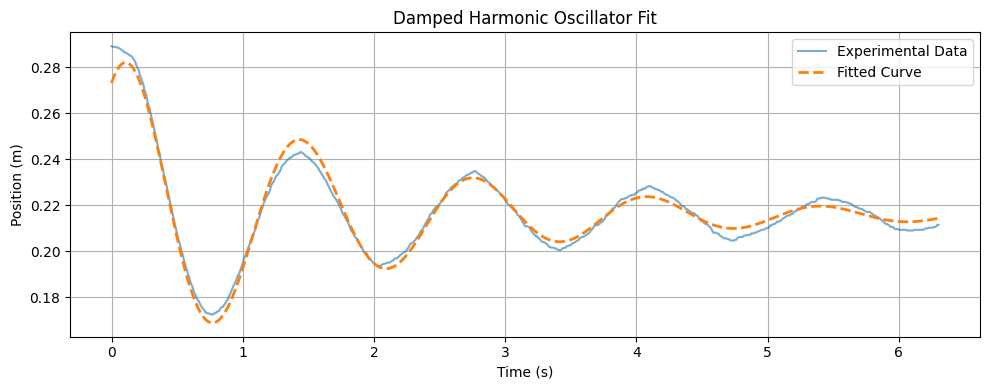

In [56]:
y_fit = damped_cosine(t, *popt)

plt.figure(figsize=(10, 4))
plt.plot(t, y, label="Experimental Data", alpha=0.6)
plt.plot(t, y_fit, label="Fitted Curve", linestyle="--", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Damped Harmonic Oscillator Fit")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [57]:
print(f"A = {A:.4f}, zeta = {zeta:.4f}, omega = {omega:.4f}, phi = {phi:.4f}, C = {C:.4f}")


A = 0.0709, zeta = 0.1110, omega = 4.7783, phi = -0.6219, C = 0.2156


$$
\frac{d^2y}{dt^2} + 2\zeta \omega \frac{dy}{dt} +\omega^2y = 0
$$

In [58]:
t_data = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
y_data = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

y_data = y_data - 0.21

In [117]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.net(t)


In [118]:
model = PINN()

# Learnable damping and frequency
log_zeta = torch.nn.Parameter(torch.tensor(-0.2))   # learn log(zeta)
log_omega = torch.nn.Parameter(torch.tensor(4.0))   # learn log(omega)

zeta = 0.7 * torch.sigmoid(log_zeta)  # forces 0 < ζ < 0.9
omega = torch.nn.functional.softplus(log_omega)

params = list(model.parameters()) + [log_zeta, log_omega]
optimizer = torch.optim.Adam(params, lr=0.005)

In [119]:
for epoch in range(10000):
    t_input = t_data.clone().detach().requires_grad_(True)
    y_hat = model(t_input)

    dy_dt = torch.autograd.grad(y_hat, t_input, torch.ones_like(y_hat), create_graph=True, retain_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, t_input, torch.ones_like(dy_dt), create_graph=True)[0]

    # Recompute zeta and omega at each step
    zeta = torch.nn.functional.softplus(log_zeta)
    omega = torch.nn.functional.softplus(log_omega)

    t0 = torch.tensor([[0.0]], requires_grad=True)
    y0_hat = model(t0)
    dy0_hat = torch.autograd.grad(y0_hat, t0, torch.ones_like(y0_hat), create_graph=True)[0]
    y0_true = y_data[0]  # From your actual data
    ic_loss = (y0_hat - y0_true)**2 + dy0_hat**2

    # ODE residual
    residual = d2y_dt2 + 2*zeta*omega*dy_dt + omega**2 * y_hat
    ode_loss = torch.mean(residual**2)

    # Data fitting loss
    data_loss = torch.mean((y_hat - y_data)**2)

    loss = 5 *ode_loss + 5 * data_loss + 5* ic_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, zeta = {zeta.item():.4f}, omega = {omega.item():.4f}, {ode_loss}, {data_loss}, {ic_loss}")

Epoch 0: Loss = 17.835911, zeta = 0.5981, omega = 4.0181, 3.449136257171631, 0.015125527046620846, tensor([[0.0316]], grad_fn=<AddBackward0>)
Epoch 500: Loss = 0.262694, zeta = 0.3768, omega = 4.0766, 0.00045211659744381905, 0.0004329666553530842, tensor([[0.0051]], grad_fn=<AddBackward0>)


KeyboardInterrupt: 

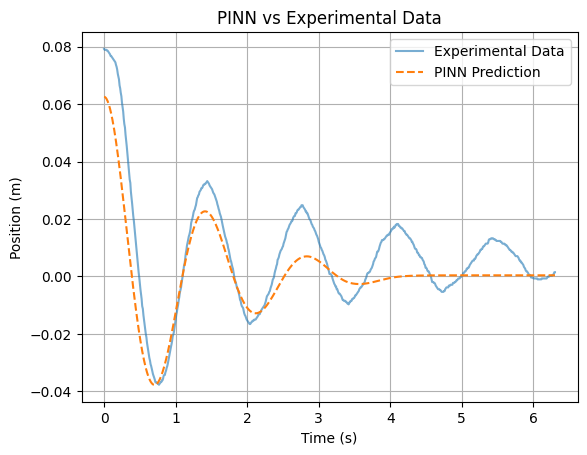

In [112]:
t_test = t_data.detach().numpy().flatten()
with torch.no_grad():
    y_pinn = model(t_data).numpy().flatten()

plt.plot(t_test, y, label="Experimental Data", alpha=0.6)
plt.plot(t_test, y_pinn, label="PINN Prediction", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("PINN vs Experimental Data")
plt.legend()
plt.grid()
plt.show()